<p align="center"><img src="https://raw.githubusercontent.com/Empa-Teknoloji/AI_Workshop/master/Additionals/Empa-Workshops-Template-Banner2.png" alt="Accelerator Workshops" style="display: block; margin: 0 auto" height=/></p>

# 1) Vitis-AI ile FPGA Platformlarında AI Uygulamaları Geliştirme
Empa Electronics tarafından düzenlenen Accelerators Workshops serimizin Uçta Yapay Zeka adımına hoşgeldiniz.  
Bu kılavuz, modern makine öğrenimi yaklaşımlarıyla geliştirilmiş bir yapay zeka/derin öğrenme çözümünün Vitis-AI geliştirme ortamı araçları kullanılarak FPGA tabanlı platformlara implementasyonu adımlarının deneyimlenmesinde size rehberlik edecektir.

Aktivite içeriği olan "Yolov5 derin öğrenme mimarisi ile nesne tespiti" uygulamasının adımları, AMD'nin Kria ürün serisine ait KV260 geliştirme kartı üzerinde adımlarla açıklanacaktır. Kullanılan model mimarisi, kart üzerindeki FPGA yapısı bloğu için AMD tarafından tasarlanmış DPU IP desteğiyle çalıştırılacak ve Vitis-AI ortamı araçları yardımıyla yapay zeka çözümü haline getirilecektir.

**Uygulama Adımları**

1- Modelin Değerlendirilmesi (Inspection)  

2- Vitis-AI DPU Desteği İçin Model Modifikasyonu  

3- Modifikasyon ve Eğitim Sonrası Model  

4- Modelin Doğrulanması (Inspection + Prediction)  

5- Modifikasyon Sonrası Gereksinimler

6- Post-processing ve Tahminlerin Eldesi

7- Model Quantization Adımı

8- Modelin Hedef Platform İçin Derlenmesi

## 1. Modelin Değerlendirilmesi

Gerekli modüllerin dahil edilmesi:

In [1]:
!pip install torchinfo

import torch
from torch import nn
from models.common import DetectMultiBackend
from PIL import Image
import cv2
import numpy as np

from utils.general import check_version, non_max_suppression

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.7/616.7 kB 1.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of ultralytics to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.9/614.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.4/614.4 kB 931.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.9/606.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 1.1 MB/s eta 0:00:00


In [2]:
target_architecture = "DPUCZDX8G_ISA1_B4096"

In [3]:
def inspect_model(model, device, image_shape, outdir):
    # import model inspector
    from pytorch_nndct import Inspector
    
    # define a dummy input
    c, h, w = image_shape
    input_dummy = torch.randn(1, c, w, h).to(device)
    device = torch.device(device)

    inspector = Inspector(target_architecture)
    inspector.inspect(model, (input_dummy,), device=device, output_dir=outdir, image_format="png")

_Bu adımın gösterimi uygulamalı olarak yapılacaktır._

## 2. Vitis-AI Desteği İçin Model Modifikasyonu

_Bu adımın gösterimi uygulamalı olarak yapılacaktır._

## 3. Modifikasyon ve Eğitim Sonrası Model

Konfigürasyon için gerekli parametrelerin tanımlanması:

In [4]:
path_model = "/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/yolov5s_epoch35.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = (540, 960)
IMG_CHANNELS = 3

Yeniden düzenlenmiş ve eğitilmiş modelin yüklenmesi:

In [5]:
def import_model(path_model, device_type):
    device = torch.device(device_type)
    model = DetectMultiBackend(weights=path_model, device=device)
    return model

In [6]:
model = import_model(path_model, device)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients


Model mimarisine bakış:

In [7]:
model

DetectMultiBackend(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): C

## 4- Modelin Doğrulanması

Modelin tahmin ile testi için gerekli fonksiyonunun tanımlanması:

In [8]:
augment = False
visualize = False

def execute_model(model, img):

    from PIL import Image
    from torchvision.transforms import Compose, ToTensor, Resize

    transforms = Compose([
        ToTensor(),
        Resize(size=(540, 960)), 
    ])

    img = transforms(img)
    img = img.unsqueeze(0).cuda()

    pred = model(img, augment=augment, visualize = visualize)
    return pred

Modelin sonuçlarınının görselleştirilmesi için gerekli fonksiyonun tanımlanması:

In [9]:
def draw_bbox(image, preds_nms):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (960, 540))
    
    for ind, pred in enumerate(preds_nms):
        topleft = (int(pred[0]), int(pred[1]))
        bottomright = (int(pred[2]), int(pred[3]))
        print(f"Object instance: {ind} | topleft: {topleft}, bottomright: {bottomright}")
        
        cv2.rectangle(image, topleft, bottomright, (255, 0, 0), 2)

    image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
    return image

Tahminleme için kullanılacak veri örneği:

In [10]:
img_original = Image.open("/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/data/images/zidane.jpg")

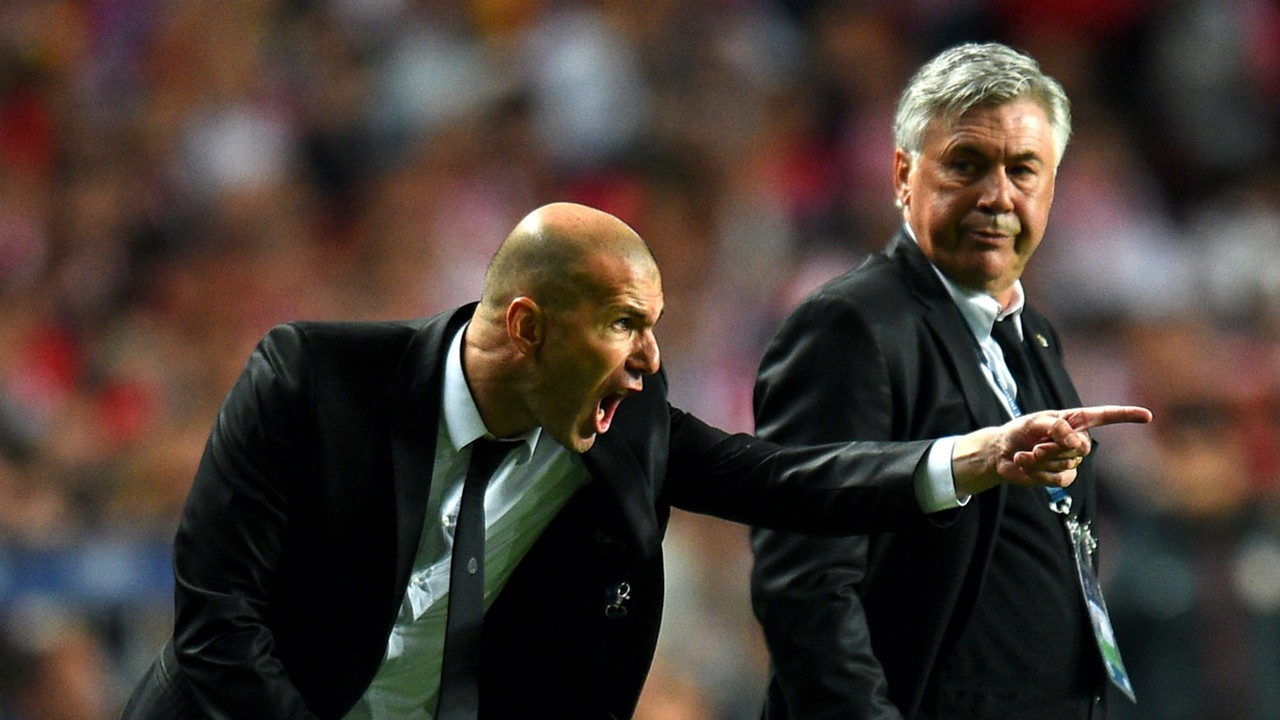

In [11]:
img_original

Modelin mevcut haliyle çıktı formatına bakış:

In [12]:
# predict an image sample using the trained model 
predictions_float = execute_model(model, img_original)
# preds_test = postprocessing(pred_raw_plain, model_test)

print(f"Number of elements: {len(predictions_float)}")
print(predictions_float[0].shape, predictions_float[1].shape, predictions_float[2].shape, sep="\n")

Number of elements: 3
torch.Size([1, 255, 68, 120])
torch.Size([1, 255, 34, 60])
torch.Size([1, 255, 17, 30])


Modelin mevcut haliyle DPU uyumluluğunun kontrolü:

In [13]:
inspect_model(model, device, (IMG_CHANNELS, IMG_SIZE[0], IMG_SIZE[1]), 
              outdir="/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/inspection_results_modified")


[VAIQ_NOTE]: Loading NNDCT kernels...

[VAIQ_NOTE]: Inspector is on.

[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing DetectMultiBackend...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model DetectMultiBackend is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 144/144 [00:00<00:00, 437.60it/s, OpInfo: name = return_0, type = Return]                                                                                                                     



[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_WARN][QUANTIZER_TORCH_LEAKYRELU]: Preserve negative_slope(0.1015625) of LeakyReLU without quantization.

[VAIQ_NOTE]: =>Quantizable module is generated.(/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/inspection_results_modified/DetectMultiBackend.py)

[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Conv[cv2]/Conv2d[conv]/input.21, op type:nndct_conv2d, output shape: [1, 240, 135, 32]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Conv[cv2]/LeakyReLU[act]/8092, op type:nndct_leaky_relu, output shape: [1, 240, 135, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[17]/Conv[cv3]/Conv2d[conv]/input.171, op type:nndct_conv2d, output shape: [1, 120, 68, 128]
node name:DetectMultiBackend::DetectMul

I20240607 03:31:25.360183  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:25.360213  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:25.360229  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:25.360309  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_4e1ldL2WVzTKqhZg, with op num: 9
I20240607 03:31:25.360319  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:25.367250  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240607 03:31:25.367290  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:25.374153  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:25.374181  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:25.374192  3180 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/input.19, op type:nndct_conv2d, output shape: [1, 240, 135, 32]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Sequential[m]/Bottleneck[0]/Conv[cv2]/LeakyReLU[act]/8069, op type:nndct_leaky_relu, output shape: [1, 240, 135, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[17]/Conv[cv1]/Conv2d[conv]/input.157, op type:nndct_conv2d, output shape: [1, 120, 68, 64]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[17]/Conv[cv1]/LeakyReLU[act]/input.159, op type:nndct_leaky_relu, output shape: [1, 120, 68, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv

I20240607 03:31:25.496683  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:25.496727  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:25.496747  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:25.496866  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_TuY8txIAOq6diwys, with op num: 9
I20240607 03:31:25.496889  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:25.597093  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240607 03:31:25.597134  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:25.607462  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:25.607494  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:25.607507  3180 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[2]/Conv[cv1]/Conv2d[conv]/input.83, op type:nndct_conv2d, output shape: [1, 60, 34, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[2]/Conv[cv1]/LeakyReLU[act]/input.85, op type:nndct_leaky_relu, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Sequential[m]/Bottleneck[1]/Conv[cv2]/Conv2d[conv]/input.49, op type:nndct_conv2d, output shape: [1, 120, 68, 64]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Sequential[m]/Bottleneck[1]/Conv[cv2]/LeakyReLU[act]/8244, op type:nndct_leaky_relu, output shape: [1, 120, 68, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectM

I20240607 03:31:25.856215  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:25.856281  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:25.856294  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:25.856468  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_n9QPxzDlHKJS52GZ, with op num: 9
I20240607 03:31:25.856484  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:25.869388  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240607 03:31:25.869489  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:25.879573  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:25.879642  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:25.879657  3180 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Conv[cv1]/Conv2d[conv]/input.101, op type:nndct_conv2d, output shape: [1, 30, 17, 256]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Conv[cv1]/LeakyReLU[act]/input.103, op type:nndct_leaky_relu, output shape: [1, 30, 17, 256]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[17]/Sequential[m]/Bottleneck[0]/Conv[cv1]/Conv2d[conv]/input.161, op type:nndct_conv2d, output shape: [1, 120, 68, 64]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[17]/Sequential[m]/Bottleneck[0]/Conv[cv1]/LeakyReLU[act]/input.163, op type:nndct_leaky_relu, output shape: [1, 120, 68, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3

I20240607 03:31:26.073137  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:26.073192  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.073210  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:26.073312  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_t8yoS9Ej7F1C5XuU, with op num: 9
I20240607 03:31:26.073325  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:26.080904  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240607 03:31:26.080941  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:26.088986  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:26.089021  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.089040  3180 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Conv[cv3]/Conv2d[conv]/input.115, op type:nndct_conv2d, output shape: [1, 30, 17, 512]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Conv[cv3]/LeakyReLU[act]/input.117, op type:nndct_leaky_relu, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Sequential[m]/Bottleneck[1]/Conv[cv1]/Conv2d[conv]/input.45, op type:nndct_conv2d, output shape: [1, 120, 68, 64]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Sequential[m]/Bottleneck[1]/Conv[cv1]/LeakyReLU[act]/input.47, op type:nndct_leaky_relu, output shape: [1, 120, 68, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/

I20240607 03:31:26.285836  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:26.285872  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.285887  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:26.286007  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_vFQ2LTZHEXNOK6Wb, with op num: 9
I20240607 03:31:26.286022  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:26.304193  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240607 03:31:26.304236  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:26.312079  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:26.312110  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.312121  3180 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/input.187, op type:nndct_conv2d, output shape: [1, 60, 34, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Sequential[m]/Bottleneck[0]/Conv[cv2]/LeakyReLU[act]/9089, op type:nndct_leaky_relu, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Conv[cv3]/Conv2d[conv]/input.55, op type:nndct_conv2d, output shape: [1, 120, 68, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Conv[cv3]/LeakyReLU[act]/input.57, op type:nndct_leaky_relu, output shape: [1, 120, 68, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/SPPF[model]/SPPF[

I20240607 03:31:26.507411  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:26.507468  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.507483  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:26.507630  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_8o1jfwdbUJAZ6cnu, with op num: 9
I20240607 03:31:26.507647  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:26.523581  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240607 03:31:26.523633  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:26.532634  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:26.532714  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.532735  3180 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Sequential[m]/Bottleneck[0]/Conv[cv1]/Conv2d[conv]/input.183, op type:nndct_conv2d, output shape: [1, 60, 34, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Sequential[m]/Bottleneck[0]/Conv[cv1]/LeakyReLU[act]/input.185, op type:nndct_leaky_relu, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[14]/Conv2d[conv]/input.151, op type:nndct_conv2d, output shape: [1, 60, 34, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[14]/LeakyReLU[act]/input.153, op type:nndct_leaky_relu, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Seque

I20240607 03:31:26.674772  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.674791  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:26.674899  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_W9NQkE4tBIxghwdb, with op num: 9
I20240607 03:31:26.674912  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:26.728196  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240607 03:31:26.728238  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:26.736179  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:26.736214  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.736227  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I2024060


[VAIQ_NOTE]: Find subgraph for resize_fix_7:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Upsample[model]/Upsample[11]/8754, op type:nndct_resize, output shape: [1, 60, 34, 256]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/input.113, op type:nndct_concat, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/input.145, op type:nndct_concat, output shape: [1, 60, 34, 256]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Concat[model]/Concat[16]/input.155, op type:nndct_concat, output shape: [1, 120, 68, 256]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/input.91, op type:nndct_concat, output shape: [1

I20240607 03:31:26.943785  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:26.943815  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.943826  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:26.943914  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_resize_POXklJLU8vn9iEb0, with op num: 4
I20240607 03:31:26.943926  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:26.947849  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240607 03:31:26.947892  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:26.973661  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:26.973695  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:26.973707  3180 compile_pass_mana


[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/input.191, op type:nndct_concat, output shape: [1, 60, 34, 256]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Concat[model]/Concat[19]/input.177, op type:nndct_concat, output shape: [1, 60, 34, 256]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/Conv2d[m]/ModuleList[0]/9285, op type:nndct_conv2d, output shape: [1, 120, 68, 255]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[model]/Detect[24]/Conv2d[m]/ModuleList[1]/9304, op type:nndct_conv2d, output shape: [1, 60, 34, 255]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Detect[mo

I20240607 03:31:27.150543  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:27.150583  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:27.150596  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:27.150701  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_concat_o368Q1pwxmcYOJf0, with op num: 6
I20240607 03:31:27.150718  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:27.156682  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 4, DPU subgraph number 1
I20240607 03:31:27.156749  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:27.164198  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:27.164232  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:27.164245  3180 compile_pass_mana


[VAIQ_NOTE]: Find subgraph for eltwise_fix_24:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[0]/input.73, op type:nndct_elemwise_add, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_24:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Sequential[m]/Bottleneck[0]/8071, op type:nndct_elemwise_add, output shape: [1, 240, 135, 32]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_24:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/Sequential[m]/Bottleneck[0]/8596, op type:nndct_elemwise_add, output shape: [1, 30, 17, 256]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_24:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Sequential[m]/Bottleneck[0]/input.43, op type:nndct_elemwise_add, output shape: [1, 120, 68, 64]



[VAIQ_NOTE]: All the operators are assigned to the DPU(see more detail

I20240607 03:31:27.355957  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:27.356104  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:27.356137  3180 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240607 03:31:27.356384  3180 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_elemwise_add_zRm7k2gfs89a4qFH, with op num: 6
I20240607 03:31:27.356411  3180 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20240607 03:31:27.363723  3180 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 4, DPU subgraph number 1
I20240607 03:31:27.363793  3180 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20240607 03:31:27.373302  3180 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20240607 03:31:27.373347  3180 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20240607 03:31:27.373363  3180 compile_pas


[VAIQ_NOTE]: Dot image is generated.(/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/inspection_results_modified/inspect_DPUCZDX8G_ISA1_B4096.png)

[VAIQ_NOTE]: =>Finish inspecting.


In [14]:
torch.save(model, "/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/model_float/model_yolov5s_modified.pt")

## 5. Modifikasyon Sonrası Gereksinimler

Modelin düzenlenmesi sırasından model yapısından çıkarılan adımların farklı platformda (CPU) yürütülebilmesi için gerekli fonksiyonların tanımlanması:

In [14]:
from utils.general import check_version, non_max_suppression

In [15]:
def get_model_attr(model):
    head = model.model.model[-1]
    nl = head.nl
    na = head.na
    no = head.no
    nc = head.nc
    dynamic = head.dynamic
    grid = head.grid
    anchor_grid = head.anchor_grid
    stride = head.stride
    anchors = head.anchors
    return [nl, na, no, nc], [dynamic, anchors, stride, grid, anchor_grid]

def write_model_attr(model, name):
    head = model.model.model[-1]
    dict_attr = dict()
    dict_attr['nl'] = head.nl
    dict_attr['na'] = head.na
    dict_attr['no'] = head.no
    dict_attr['nc'] = head.nc
    dict_attr['dynamic'] = head.dynamic
    dict_attr['grid'] = head.grid
    dict_attr['anchor_grid'] = head.anchor_grid
    dict_attr['stride'] = head.stride
    dict_attr['anchors'] = head.anchors

    torch.save(dict_attr, f"{name}.attributes")

def read_model_attr(path_attributes):
    dict_attr = torch.load(path_attributes)
    return [dict_attr['nl'], dict_attr['na'], dict_attr['no'], dict_attr['nc']], [dict_attr['dynamic'], dict_attr['anchors'], dict_attr['stride'], dict_attr['grid'], dict_attr['anchor_grid']]


def _make_grid(nx=20, ny=20, i=0, torch_1_10=check_version(torch.__version__, "1.10.0"), na=None, anchors=None, stride=None):
        d = anchors[i].device
        t = anchors[i].dtype
        shape = 1, na, ny, nx, 2  # grid shape
        y, x = torch.arange(ny, device=d, dtype=t), torch.arange(nx, device=d, dtype=t)
        yv, xv = (torch.meshgrid(y, x, indexing="ij") if torch_1_10 else torch.meshgrid(y, x))  # torch>=0.7 compatibility
        grid = (torch.stack((xv, yv), 2).expand(shape) - 0.5).float()  # add grid offset, i.e. y = 2.0 * x - 0.5
        anchor_grid = ((anchors[i].clone() * stride[i]).view((1, na, 1, 1, 2)).expand(shape)).float()
        return grid, anchor_grid

def postprocessing(x, model):

    [nl, na, no, nc], [dynamic, anchors, stride, grid, anchor_grid] = get_model_attr(model)

    z = []  # inference output
    for i in range(nl):
        # print(x[i].shape)
        bs, _, ny, nx = x[i].shape  # x(bs,255,20,20) to x(bs,3,20,20,85)
        # print("ny, nx:", ny, nx, bs)
        x[i] = x[i].view(bs, na, no, ny, nx).permute(0, 1, 3, 4, 2).contiguous()

        if dynamic or grid[i].shape[2:4] != x[i].shape[2:4]:
            grid[i], anchor_grid[i] = _make_grid(nx, ny, i, na=na, anchors=anchors, stride=stride)

        # Detect (boxes only)
        xy, wh, conf = x[i].sigmoid().split((2, 2, nc + 1), 4)
        xy = (xy * 2 + grid[i]) * stride[i]  # xy
        wh = (wh * 2) ** 2 * anchor_grid[i]  # wh
        y = torch.cat((xy, wh, conf), 4)
        z.append(y.view(bs, na * nx * ny, no))

    return (torch.cat(z, 1), x)

## 6. Post-processing ve Tahminlerin Eldesi

Ham tahminlerin elde edilmesi:

In [16]:
# ham tahminlerin elde
predictions_float = execute_model(model, img_original)

Yolo mimarisi standart postprocessing adımlarının uygulanması:

In [17]:
predictions_float_processed = postprocessing(predictions_float, model)

Non-maximum Suppression filtresinin uygulanması:

In [18]:
conf_thres=0.15     # confidence threshold
iou_thres=0.25
classes=None        # filter by class: --class 0, or --class 0 2 3
agnostic_nms=False
max_det=1000 

predictions_float_nms = non_max_suppression(predictions_float_processed, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

Object instance: 0 | topleft: (322, 326), bottomright: (387, 541)
Object instance: 1 | topleft: (548, 31), bottomright: (880, 550)
Object instance: 2 | topleft: (60, 146), bottomright: (666, 538)
Object instance: 3 | topleft: (740, 225), bottomright: (770, 319)


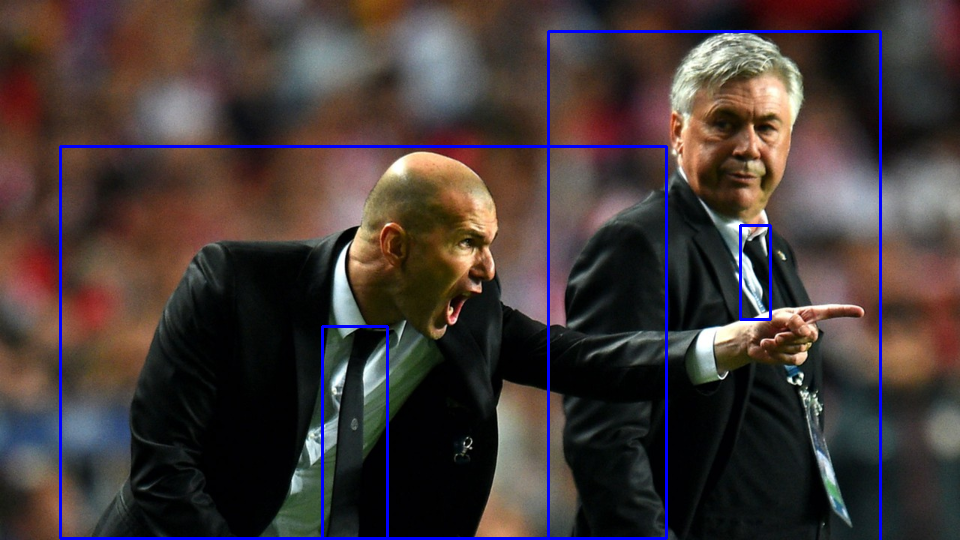

In [41]:
img_temp1 = draw_bbox(img_original, predictions_float_nms[0])
Image.fromarray(img_temp1)

## 7. Model Quantization Adımı 

Quantization için gerekli modüller:

In [19]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from random import shuffle, choices
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from utils.general import non_max_suppression

Kalibrasyon veri setinin yüklenmesi:  

_Kalibrasyon veri setinin, idealde eğitim veri setinden alınan ve etiketlere ihtiyaç olmaksızın edinilmiş yaklaşık 1000 adet veri örneğinden oluşturulması önerilmektedir._ 

In [20]:
path_dataset_calib = "/workspace/DEV/inputs/imagenet-samples/"

transforms_calib = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1]))
])

class CalibrationDatasetCreator(Dataset):
    def __init__(self, path_calib_root, transforms, stability_check=True):
        self.path_calib_root = Path(path_calib_root)
        self.transforms = transforms
        self.list_image_paths = list(self.path_calib_root.rglob("*JPEG"))
        if stability_check:
            self.list_image_paths = [path for path in self.list_image_paths if np.array(Image.open(str(path))).shape[-1] == 3]

    def __len__(self):
        return len(self.list_image_paths)

    def __getitem__(self, ind):
        path_image = str(self.list_image_paths[ind])
        image = Image.open(path_image)
        if self.transforms:
            image = self.transforms(image)
        return image
    
dataset_calib = CalibrationDatasetCreator(path_dataset_calib, transforms_calib)

In [21]:
def print_shapes(dataset, label_exist=True):
    print("validation dataset size:", len(dataset))
    for data in dataset:
        if label_exist: 
            x,y = data
        else:
            x = data
        print("sample shape:\n\t", x.shape)
        if label_exist:
            print("label shape:\n\t", len(y))
        break

In [22]:
print_shapes(dataset_calib, label_exist=False)

validation dataset size: 977
sample shape:
	 torch.Size([3, 540, 960])


Kuantalama işlemi içerisinde gerekli olan forward-pass işlemi ve metrik ölçümü amacıyla oluşturulan foksiyon: 

In [23]:
def evaluate_model(model_instance, dataset, device, batch=None):

    model_instance.eval()

    if batch:
        dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)

    with torch.no_grad():
        for data in dataloader:
            if isinstance(data, (list, tuple)):
                X, y = data
                y = y.to(device)
            elif isinstance(data, torch.Tensor):
                X = data
            else: 
                raise TypeError
        
            X = X.to(device)
            outs = model_instance(X)
            preds = non_max_suppression(outs)

Vitis-AI Quantizer için mod seçimi parametreleri:

In [25]:
batch_size = 1
quant_mode = "test"

Kuantalama adımları:

- Vitis-AI Quantizerın kullanımı esnasında ilk önce, aracın "calib" ile çalıştırılması ve veri temelli istatistiklerin kayıt edilmesi gerekmektedir.
- Ardından aracın "test" modunda batch_size=1 ile çalıştırılması ile kuantalama işleminden geçirilen modelin kayıt işlemi gerçekleştirilebilmektedir. 

In [26]:
# Step-1) importing the pytorch quantizer
from pytorch_nndct.apis import torch_quantizer

# set batch_size to 1 when 'test' is selected
if quant_mode == 'test':
    batch_size = 1

# Step-2) create quantizer object instance with given input
input_calib = torch.randn([batch_size, 3, 640, 640])
quantizer = torch_quantizer(quant_mode=quant_mode, 
                            module=model, 
                            input_args=(input_calib),
                            output_dir="/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/model_quantized")
print("Quantizer is defined.")

# Step-3) get the converted model to forward the model using calibration subset
model_quantized = quantizer.quant_model
print("Quantized model is created.")

# Step-4) organize model evaluation function and dataset & forward-pass the model using eval. func.
# if quant_mode == 'calib':
evaluate_model(model_quantized, dataset_calib, device, batch=batch_size)
print("Evaluation func. is called.")

# Step-5) export calibration configs first
if quant_mode == 'calib':
    quantizer.export_quant_config()

# Step-6) export quantized model
if quant_mode == 'test':
    quantizer.export_xmodel(deploy_check=False, output_dir="/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/model_quantized")
    print("Quantized xmodel file is saved.")


[VAIQ_NOTE]: OS and CPU information:
               system --- Linux
                 node --- empa
              release --- 5.15.0-107-generic
              version --- #117~20.04.1-Ubuntu SMP Tue Apr 30 10:35:57 UTC 2024
              machine --- x86_64
            processor --- x86_64

[VAIQ_NOTE]: Tools version information:
                  GCC --- GCC 9.4.0
               python --- 3.7.12
              pytorch --- 1.12.1
        vai_q_pytorch --- 3.0.0+a44284e+torch1.12.1

[VAIQ_NOTE]: GPU information:
          device name --- NVIDIA GeForce RTX 3060 Laptop GPU
     device available --- True
         device count --- 1
       current device --- 0



[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization calibration process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing DetectMultiBackend...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model DetectMultiBackend is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 144/144 [00:00<00:00, 518.02it/s, OpInfo: name = return_0, type = Return]                                                                                                                      



[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/model_quantized/DetectMultiBackend.py)
Quantizer is defined.

[VAIQ_NOTE]: =>Get module with quantization.
Quantized model is created.

[VAIQ_WARN]: The shape of input (torch.Size([3, 540, 960])) should be the same with that of dummy input ([3, 640, 640])
Evaluation func. is called.

[VAIQ_NOTE]: =>Exporting quant config.(/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/model_quantized/quant_info.json)


In [40]:
model_quantized

DetectMultiBackend(
  (module_0): deephi_Input()
  (module_1): deephi_Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (module_2): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_3): deephi_Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (module_4): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_5): deephi_Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (module_6): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_7): deephi_Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (module_8): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_9): deephi_Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_10): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_11): deephi_Add()
  (module_12): deephi_Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (module_13): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_14): deephi

Object instance: 0 | topleft: (549, 23), bottomright: (882, 553)
Object instance: 1 | topleft: (327, 319), bottomright: (373, 538)
Object instance: 2 | topleft: (45, 135), bottomright: (678, 547)


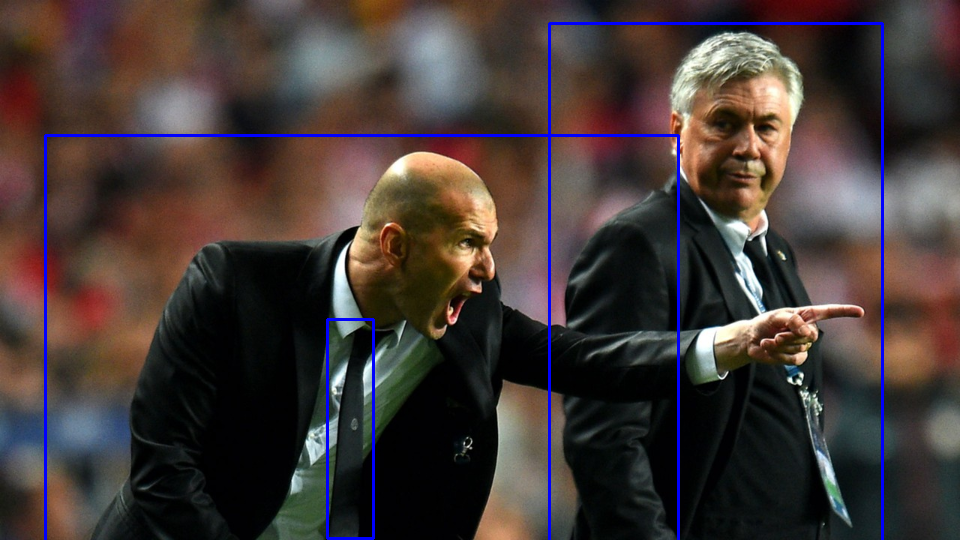

In [42]:
# ham tahminlerin elde
predictions_int8 = execute_model(model_quantized, img_original)

predictions_int8_processed = postprocessing(list(predictions_int8), model)

conf_thres=0.15     # confidence threshold
iou_thres=0.25
classes=None        # filter by class: --class 0, or --class 0 2 3
agnostic_nms=False
max_det=1000 
predictions_float_nms = non_max_suppression(predictions_int8_processed, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

img_temp1 = draw_bbox(img_original, predictions_float_nms[0])
Image.fromarray(img_temp1)

## 8. Modelin Hedef Platform İçin Derlenmesi 

Derleme için gerekli Vitis-AI modüllerinin dahil edilmesi:

In [27]:
from vaic.xcompiler_interface import xcompiler
import json

Derleme için gerekli konfigürasyon değişkenleri:

In [28]:
xmodel_path = "/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/model_quantized/DetectMultiBackend_int.xmodel"
arch_name = "DPUCZDX8G"
target_name = "KV260"
path_arch = f"/opt/vitis_ai/compiler/arch/{arch_name}/{target_name}/arch.json"
net_name = "YoloV5s_workshop"
output_dir_name = "model_compiled"

Derleme işlemi için kod adımları:

In [46]:
# define compiler parameters dictionary
compiler_params = {
	'parser': 'xir',
	'xmodel': str(xmodel_path),
	'net_name': net_name,
	'output_dir': 'Vitis-AI-Experiment/'+str(output_dir_name)
        }

# read arch fingerprint using arch.json
with open(path_arch) as json_data:
	if json_data: arch_data = json.load(json_data)

# add arch fingerprint to parameters dictionary
if arch_data and 'target' in arch_data:
	compiler_params['target'] = arch_data['target']
elif arch_data and 'fingerprint' in arch_data:
	compiler_params['fingerprint'] = arch_data['fingerprint']

# execute compiling process
xcompiler(compiler_params).compile()

[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: null
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: DetectMultiBackend, with op num: 448
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 5, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/model_compiled/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/model_compiled/YoloV5s_workshop.xmodel"
[UNILOG][INFO] The compiled xmodel's md5sum is be8d18982b5f216abb1a4a08b23f9fde, and has been saved to "/workspace/DEV/models/pt_detection_yolov5_workshop/yolov5/Vitis-AI-Experiment/model_compiled/md5sum.txt"
